<a href="https://colab.research.google.com/github/FutureOfTed/AI-class/blob/main/Week11/AE_WISDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [14]:
# 사용할 활동 정의
NORMAL_ACTIVITY = 'Jogging'
ANOMALY_ACTIVITY = 'Sitting'

결측치 존재 여부: False
필터링된 데이터셋 크기: (380851, 8)


/tmp/ipython-input-1291862708.py:20: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df_filtered['Anomaly_Class'], sort=True)


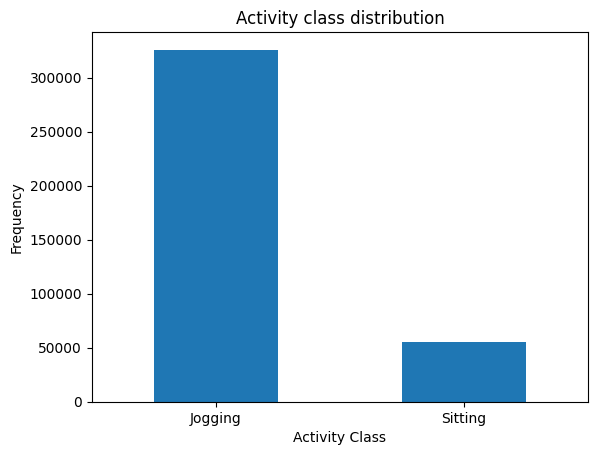

X_train shape: (260779, 3)
X_test shape: (76171, 3)


In [16]:
# 1. 데이터 로드 및 전처리
# WISDM 데이터셋을 불러옵니다. (헤더가 없고, 인덱스, 사용자 ID, 활동, 타임스탬프, X, Y, Z로 구성된 형식 가정)
column_names = ['Index', 'User', 'Activity', 'Timestamp', 'X', 'Y', 'Z']
df = pd.read_csv('/content/drive/MyDrive/data/WISDM.csv', header=None, names=column_names)

# Activity 컬럼의 값들 확인 및 정리 (공백 제거)
df['Activity'] = df['Activity'].str.strip()

# 'Jogging'과 'Sitting' 데이터만 필터링
df_filtered = df[df['Activity'].isin([NORMAL_ACTIVITY, ANOMALY_ACTIVITY])].copy()

# Anomaly_Class 생성 (Jogging: 0, Sitting: 1)
df_filtered['Anomaly_Class'] = df_filtered['Activity'].apply(lambda x: 0 if x == NORMAL_ACTIVITY else 1)

print(f"결측치 존재 여부: {df_filtered.isnull().values.any()}")
print(f"필터링된 데이터셋 크기: {df_filtered.shape}")

# 클래스 분포 확인 및 시각화 (코드 실행 결과는 이미지로 제공됩니다)
LABELS = [NORMAL_ACTIVITY, ANOMALY_ACTIVITY]
count_classes = pd.value_counts(df_filtered['Anomaly_Class'], sort=True)
plt.figure()
count_classes.plot(kind='bar', rot=0)
plt.title("Activity class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Activity Class")
plt.ylabel("Frequency")
plt.show()

# 특징(Feature) 선택: 가속도 값 (X, Y, Z)
features = ['X', 'Y', 'Z']
data = df_filtered[features + ['Anomaly_Class']].copy()

# 특징 데이터 표준화 (Standardization)
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# 훈련/테스트 데이터 분리 (이상/정상 비율 유지를 위해 stratify 사용)
RANDOM_SEED = 42

X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, stratify=data['Anomaly_Class'])

# 훈련 데이터는 정상 활동(Jogging, Anomaly_Class=0)만 사용
X_train_normal = X_train[X_train['Anomaly_Class'] == 0].drop(['Anomaly_Class'], axis=1)

# 테스트 데이터 준비 (클래스 레이블 분리)
y_test = X_test['Anomaly_Class']
X_test = X_test.drop(['Anomaly_Class'], axis=1)

# NumPy 배열로 변환
X_train = X_train_normal.values
X_test = X_test.values

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

In [17]:
# 2. 오토인코더 모델 정의

input_dim = X_train.shape[1] # 3 (X, Y, Z)
encoding_dim = 2 # 인코딩 차원을 설정 (3개 특징에 맞게 임의로 2로 설정)

input_layer = Input(shape=(input_dim,))
# 인코더: 3 -> 2
encoded = Dense(encoding_dim, activation='relu')(input_layer)
# 디코더: 2 -> 3
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [18]:
# 3. 모델 학습
# 훈련데이터의 0.1 을 validation data로 사용
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=1)

Epoch 1/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.1699 - val_loss: 0.9300
Epoch 2/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9116 - val_loss: 0.8795
Epoch 3/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8684 - val_loss: 0.8425
Epoch 4/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.8327 - val_loss: 0.8182
Epoch 5/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8091 - val_loss: 0.8009
Epoch 6/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7944 - val_loss: 0.7868
Epoch 7/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7786 - val_loss: 0.7751
Epoch 8/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7666 - val_loss: 0.7651
Epoch 9/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7601 - val_loss: 0.7585
Epoch 10/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7524 - val_loss: 0.7543
Epoch 11/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7472 - val_loss: 0.7516
Epoch 12/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

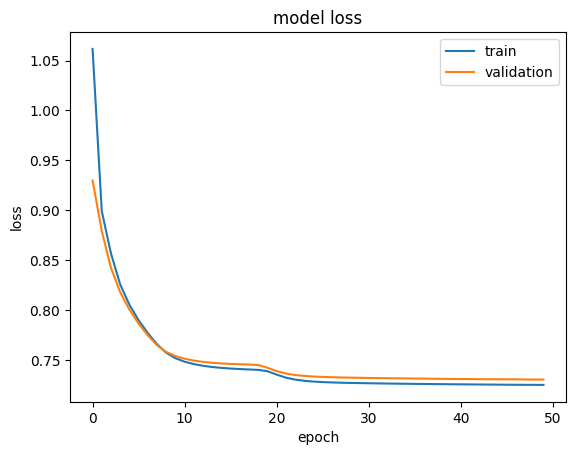

In [19]:
# 학습 곡선 시각화 (코드 실행 결과는 이미지로 제공됩니다)
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [20]:
# 4. 재구성 오류 계산 및 평가
predictions = autoencoder.predict(X_test, verbose=0)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test.values})

print("\nReconstruction Error Description:")
print(error_df.describe())


Reconstruction Error Description:
       reconstruction_error    true_class
count          76171.000000  76171.000000
mean               0.652060      0.144084
std                0.792669      0.351177
min                0.000045      0.000000
25%                0.141543      0.000000
50%                0.348490      0.000000
75%                0.840589      0.000000
max                7.085319      1.000000


In [21]:
# threshold 값 설정 (재구성 오류 통계를 바탕으로 조정)
# 표준화된 데이터의 특성을 고려하여 임의의 값 0.5로 설정
threshold = 0.5

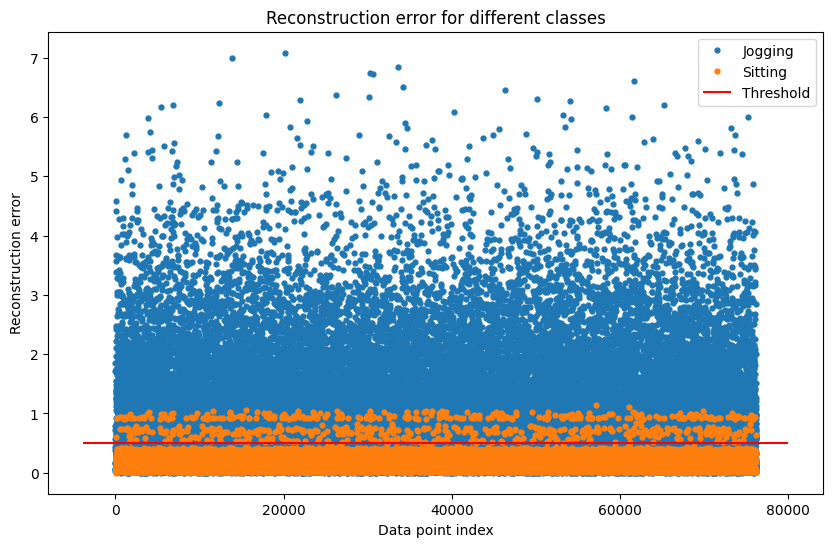

In [22]:
# 재구성 오류 시각화 (코드 실행 결과는 이미지로 제공됩니다)
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(10, 6))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label=ANOMALY_ACTIVITY if name == 1 else NORMAL_ACTIVITY)

ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

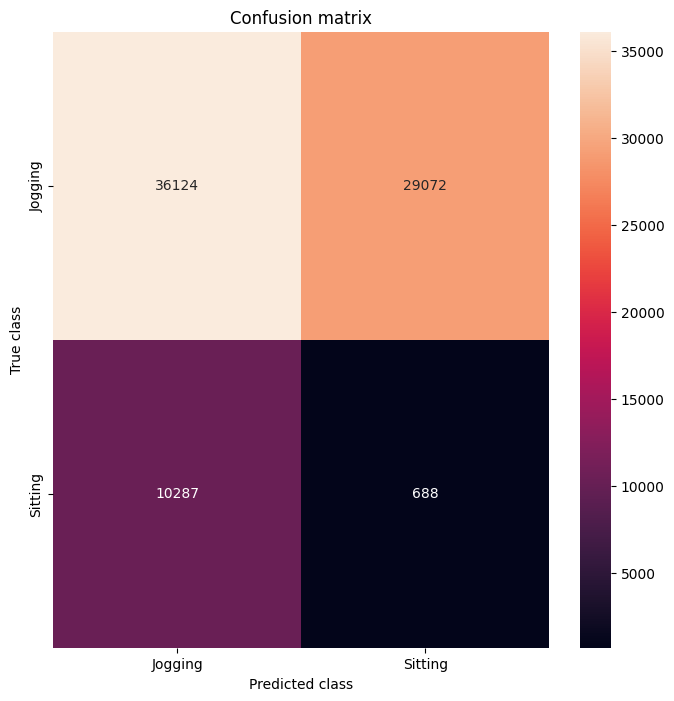

              precision    recall  f1-score   support

           0       0.78      0.55      0.65     65196
           1       0.02      0.06      0.03     10975

    accuracy                           0.48     76171
   macro avg       0.40      0.31      0.34     76171
weighted avg       0.67      0.48      0.56     76171



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(error_df.true_class, y_pred))